In [46]:
import funzioni02 as f2
import funzioni01 as f1
import qiskit.quantum_info as qi
import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
plt.rcParams['figure.figsize'] = [12, 8]

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2022-03-06 20:11:09,913: Credentials are already in use. The existing account in the session will be replaced.


In [47]:
name="fid_vs_time_06-03_simu_01.txt"
f=open("dati/"+name, "r")

tempi=[]
dati_vecchia_calib=[]
dati_vecchia_calib_dev=[]

for x in f:
    if x[0]!="#":
        y=x.split(" ")
        tempi.append(float(y[0]))
        dati_vecchia_calib.append(float(y[7]))
        dati_vecchia_calib_dev.append(float(y[8]))

name="fid_vs_time_06-03_simu_02.txt"
f=open("dati/"+name, "r")

tempi_2=[]
dati_vecchia_calib_2=[]
dati_vecchia_calib_dev_2=[]

for x in f:
    if x[0]!="#":
        y=x.split(" ")
        tempi_2.append(float(y[0]))
        dati_vecchia_calib_2.append(float(y[7]))
        dati_vecchia_calib_dev_2.append(float(y[8]))

name="fid_vs_time_06-03_simu_03.txt"
f=open("dati/"+name, "r")

tempi_3=[]
dati_vecchia_calib_3=[]
dati_vecchia_calib_dev_3=[]

for x in f:
    if x[0]!="#":
        y=x.split(" ")
        tempi_3.append(float(y[0]))
        dati_vecchia_calib_3.append(float(y[7]))
        dati_vecchia_calib_dev_3.append(float(y[8]))


In [48]:
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [49]:
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

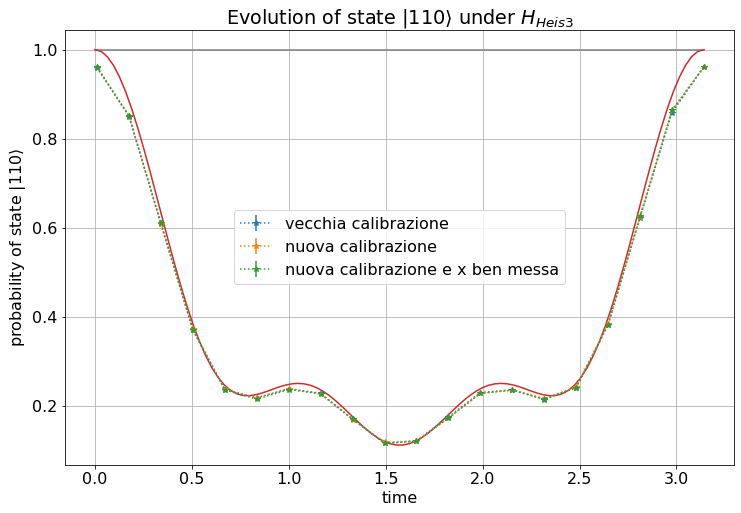

In [50]:
plt.errorbar(tempi, dati_vecchia_calib,dati_vecchia_calib_dev,linestyle=':',marker="*",label="vecchia calibrazione")
plt.errorbar(tempi_2, dati_vecchia_calib_2,dati_vecchia_calib_dev_2,linestyle=':',marker="*",label="nuova calibrazione")
plt.errorbar(tempi_3, dati_vecchia_calib_3,dati_vecchia_calib_dev_3,linestyle=':',marker="*",label="nuova calibrazione e x ben messa")


plt.plot([0,np.pi],[1,1],color="gray")
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.legend()
plt.grid()

plt.show()

20 20


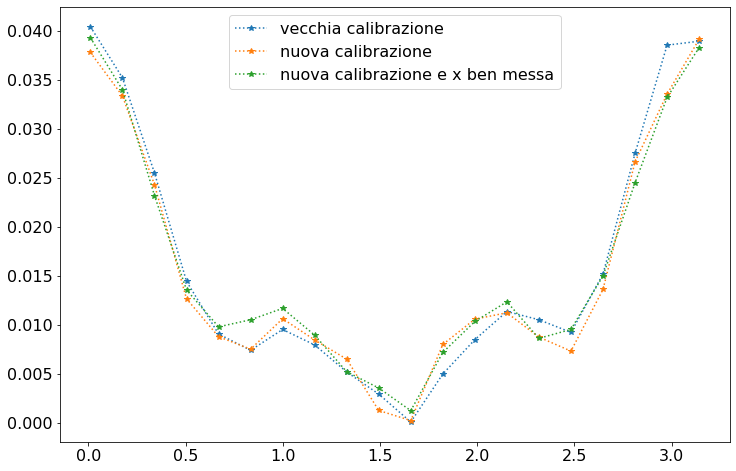

In [53]:
initial_state = One^One^Zero
probs_110 = np.array([np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in tempi])

print(len(probs_110),len(dati_vecchia_calib))

diff_vecc=probs_110-dati_vecchia_calib
diff_nuov=probs_110-dati_vecchia_calib_2
diff_nuov_x_ben=probs_110-dati_vecchia_calib_3

plt.plot(tempi,diff_vecc, linestyle=':',marker="*",label="vecchia calibrazione")
plt.plot(tempi,diff_nuov, linestyle=':',marker="*",label="nuova calibrazione")
plt.plot(tempi,diff_nuov_x_ben, linestyle=':',marker="*",label="nuova calibrazione e x ben messa")

plt.legend()
plt.show()

In [52]:
qr_ch=QuantumRegister(6)
qc_ch=QuantumCircuit(qr_ch,name ='copy_check')

qc_ch.cx(qr_ch[3],qr_ch[0])
qc_ch.cx(qr_ch[5],qr_ch[2])
qc_ch.cx(qr_ch[3],qr_ch[1])
qc_ch.cx(qr_ch[4],qr_ch[3])
qc_ch.cx(qr_ch[3],qr_ch[1])
qc_ch.cx(qr_ch[4],qr_ch[3])

qc_ch.draw()

┌───┐                         
q15_0: ┤ X ├─────────────────────────
       └─┬─┘     ┌───┐     ┌───┐     
q15_1: ──┼───────┤ X ├─────┤ X ├─────
         │  ┌───┐└─┬─┘     └─┬─┘     
q15_2: ──┼──┤ X ├──┼─────────┼───────
         │  └─┬─┘  │  ┌───┐  │  ┌───┐
q15_3: ──■────┼────■──┤ X ├──■──┤ X ├
              │       └─┬─┘     └─┬─┘
q15_4: ───────┼─────────■─────────■──
              │                      
q15_5: ───────■──────────────────────